N = 25578, mu = 42.821, sd = 3.829
N = 5943, mu = 12.402, sd = 1.435
N = 1701, mu = 88.495, sd = 9.726


/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


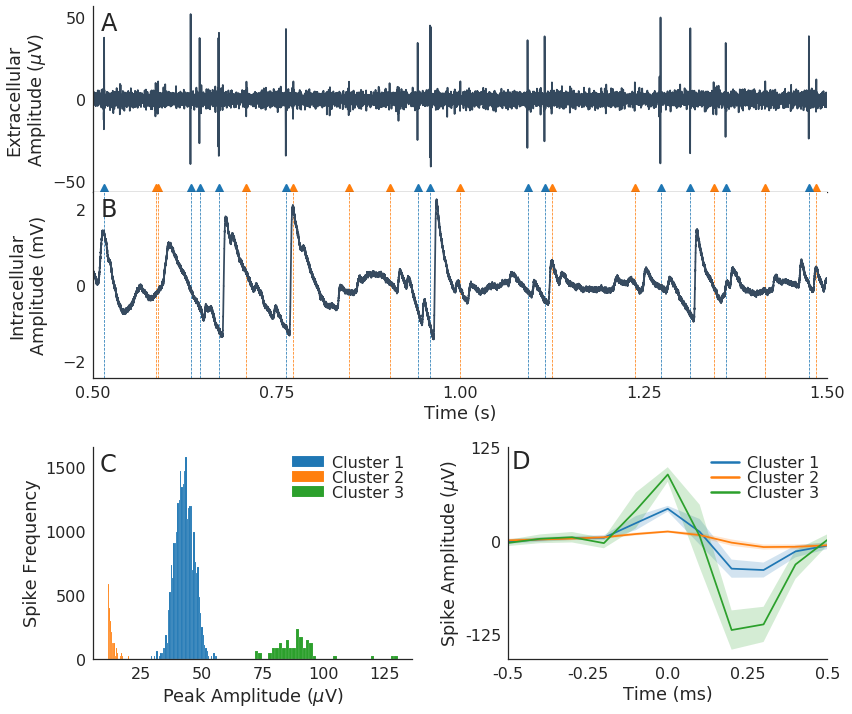

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.6)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Paired recording data.
npz = np.load('paired_recording.npz')
data = npz['data']
times = npz['times']
peak_times = npz['peak_times']
peak_mag = npz['peak_mag']

## Spike-sortking data.
df = read_csv('spike_sorting.csv')

## Define categories.
categories = np.digitize(peak_mag, [25e-6, 70e-6])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,12))

## Initialize canvas for paired recording.
gs = gridspec.GridSpec(2, 1)
gs.update(left=0.1, right=0.95, bottom=0.45, hspace=0.00)

## Plot extracellular recording.
ax = plt.subplot(gs[0, 0])
ax.plot(times, data[0] * 1e6, color="#34495e")
y = np.max(np.abs(ax.get_ylim()))

for i, color in enumerate(['#ff7f0e', '#1f77b4', '#2ca02c']):
    ax.scatter(peak_times[categories==i], np.ones_like(peak_times[categories==i]) * -y * 0.95,
               marker='^', color=color, linewidth=2)
               
ax.set(xlim=(times.min(), times.max()), xticks=[], ylim=(-y, y), yticks=[-50,0,50])
ax.set_ylabel('Extracellular\n' + r'Amplitude ($\mu$V)')
ax.text(0.51, y*0.95, 'A', fontsize=24, ha='left', va='top')    

## Plot intracellular recording.
ax = plt.subplot(gs[1, 0])
ax.plot(times, data[1] * 1e3, color="#34495e", alpha=0.99)
y = np.max(np.abs(ax.get_ylim()))

for i, color in enumerate(['#ff7f0e', '#1f77b4', '#2ca02c']):
    ax.vlines(peak_times[categories==i], -y, y, lw=0.75, linestyle='--', color=color)

ax.set(xlim=(times.min(), times.max()), xticks=np.linspace(times.min(), times.max(), 5), 
       xlabel='Time (s)', ylim=(-y, y), yticks=[-2.0,0.,2.], )
ax.set_ylabel( 'Intracellular\n' + r'Amplitude (mV)', labelpad=15)
ax.text(0.51, y*0.95, 'B', fontsize=24, ha='left', va='top', zorder=20)

## Initialize canvas for spike sorting.
g2 = gridspec.GridSpec(1, 2)
g2.update(left=0.1, right=0.95, top=0.37, hspace=0.00, wspace=0.3)

## Plot histogram of spike magnitudes.
ax = plt.subplot(g2[0, 0])
for i in df.Category.unique():
    arr = df.loc[df.Category==i,'Peak Amplitude'] * 1e6
    sns.distplot(arr, kde=False, hist_kws=dict(alpha=1, edgecolor='w', linewidth=0.1), label='Cluster %s' %(i+1))    
    print('N = %s, mu = %0.3f, sd = %0.3f' %(arr.shape[0],arr.mean(),arr.std()))
    
ax.set(xlabel=r'Peak Amplitude ($\mu$V)', ylabel='Spike Frequency')
ax.legend(loc=0, borderpad=0, labelspacing=0, handletextpad=0.5)
ax.text(8, ax.get_ylim()[1]*0.976, 'C', fontsize=24, ha='left', va='top')

## Plot timecourses of spikes.
ax = plt.subplot(g2[0, 1])
xticks = np.linspace(-0.5e-3,0.5e-3,5)
yticks = np.array([-125, 0, 125]) * 1e-6

sns.tsplot(df, time='Sample', unit='Epoch', condition='Category', value='Voltage', 
           legend=False, ci='sd', ax=ax)
for i, color in enumerate(sns.color_palette(n_colors=3)): ax.plot([],[],color=color,label='Cluster %s' %(i+1), linewidth=2.5)
ax.set(xlim=(xticks.min(), xticks.max()), xticks=xticks, xticklabels=xticks*1e3, 
       xlabel='Time (ms)', yticks=yticks, yticklabels=(yticks*1e6).astype(int))
ax.set_ylabel('Spike Amplitude ($\mu$V)')
ax.legend(loc=0, borderpad=0, labelspacing=0, handletextpad=0.5, handlelength=1.75)
ax.text(-0.49e-3, ax.get_ylim()[1]*0.975, 'D', fontsize=24, ha='left', va='top')

sns.despine()
plt.savefig('crayfish_figure.png', dpi=300)